In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import gc
import glob
import re
import lightgbm as gbm
from numba import jit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import zscore

plt.style.use('fivethirtyeight')

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
@jit
def parser(x):
    return pd.to_datetime(x, format = '%m/%d/%Y %I:%M:%S %p', errors = 'coerce')
@jit
def convert2num(x):
    return x.replace('$', '')

@jit
def prep(x):
    x = x[x['Fare'].notnull() & x['Trip Seconds'].notnull() & x['Trip Miles'].notnull() & (x['Trip Seconds'] > 0) \
          & (x['Trip Miles'] > 0)]
    
    x['Fare'] = x['Fare'].apply(convert2num).astype('float')
    
    x = x[x['Fare'] > 0]
    return x

df = []

start_time = time.time()
print("Start Preprocessing...")

for path in glob.glob("D:/TAMUIDS/Chicago_taxi_trips*.csv"):
    
    generator = (pd.read_csv(path, 
                             usecols = ['Trip Start Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare'], 
                             engine = 'c', 
                             parse_dates = ['Trip Start Timestamp'],
                             date_parser = parser,
                             index_col = 'Trip Start Timestamp', 
                             chunksize = 100000))
    
    df.append(pd.concat([prep(chunk) for chunk in generator]).resample('D').median())

df = pd.concat(df)
    
print('End Preprocessing... {} seconds'.format(time.time() - start_time))

Start Preprocessing...


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
df.head()

In [ ]:
#Save The File as "clean_daily_median.csv"
df.to_csv("D:/TAMUIDS/clean_daily_median.csv")

In [2]:
# Load the data
df = pd.read_csv("D:/TAMUIDS/clean_daily_median.csv", 
                    parse_dates = ['Trip Start Timestamp'], 
                    index_col = 'Trip Start Timestamp')

df['Trip Seconds'] = zscore(df['Trip Seconds'])
df['Trip Miles'] = zscore(df['Trip Miles'])

In [3]:
zscore(df['Trip Seconds'])

array([-1.52948498, -2.85912062, -2.85912062, ..., -0.19984935,
       -0.19984935, -0.19984935])

In [4]:
def add_lags(x, lag, var):
    df = pd.DataFrame()
    for t in range(1, lag+1):
        df[var+'_lag'+str(t)] = x[var].shift(t)
    df = pd.concat((df, x), axis=1)
    return df.dropna()

In [5]:
#Test the function
add_lags(df, 6, 'Fare').head()

,Fare_lag1,Fare_lag2,Fare_lag3,Fare_lag4,Fare_lag5,Fare_lag6,Trip Seconds,Trip Miles,Fare
Trip Start Timestamp,,,,,,,,,
2013-01-07,8.44,7.85,7.45,7.45,7.65,8.65,-2.859121,0.336520,7.85
2013-01-08,7.85,8.44,7.85,7.45,7.45,7.65,-2.859121,0.164235,7.65
2013-01-09,7.65,7.85,8.44,7.85,7.45,7.45,-2.859121,0.164235,7.65
2013-01-10,7.65,7.65,7.85,8.44,7.85,7.45,-1.529485,-0.410047,7.65
2013-01-11,7.65,7.65,7.65,7.85,8.44,7.85,-1.529485,0.164235,7.85


# Models
- ARIMA
- Recurrent Neural Network (LSTM)
- Linear Regression
- Gradient Boosting Tree

# Linear Regression
- Without 'Trip Seconds' 'Trip Miles'
- With 'Trip Seconds' 'Trip Miles'

In [6]:
train_err = []
test_err = []
for k in range(1, 31):

    n_lag = k

    Inputs = add_lags(df, n_lag, 'Fare')

    Inputs['month'] = Inputs.index.month
    Inputs['weekday'] = Inputs.index.weekday

    Inputs['month'] = Inputs['month'].astype('category')
    Inputs['weekday'] = Inputs['weekday'].astype('category')

    train = Inputs['2013':'2016']
    test = Inputs['2017']

    target_var = ['Fare']
    #'Trip Seconds', 'Trip Miles'
    features = ['Fare_lag' + str(i) for i in range(1, n_lag+1)] + ['month', 'weekday']

    # One-Hot Encoding
    X_train, y_train = pd.get_dummies(train.loc[:, features]), pd.get_dummies(train.loc[:, target_var])

    X_test, y_test = pd.get_dummies(test.loc[:, features]), pd.get_dummies(test.loc[:, target_var])

    lin_regr = LinearRegression()
    lin_regr.fit(X_train, y_train)

    init_X = X_train.iloc[-1, :n_lag].values
    init_y = y_train.values[-1]

    predicitions = []
    for i in range(len(X_test)):
        if i == 0:
            X_new = np.append(init_y, init_X)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lin_regr.predict(training)
        else:
            X_new = np.append(yhat, X_new)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lin_regr.predict(training)

        predicitions.append(yhat)

    predicitions = np.array(predicitions).ravel()
    
    training_error = sqrt(mean_squared_error(lin_regr.predict(X_train), y_train.values))
    train_err.append(training_error)

    test_error = sqrt(mean_squared_error(np.array(predicitions).flatten(), y_test.values))
    test_err.append(test_error)
    
    print('n_lag = {}'.format(k))
    print("The Train Error of Linear Regression Model is : {}".format(training_error))
    print("The Test Error of Linear Regression Model is : {}".format(test_error))
    print()

n_lag = 1
The Train Error of Linear Regression Model is : 0.2602022451264952
The Test Error of Linear Regression Model is : 0.3573923401712362

n_lag = 2
The Train Error of Linear Regression Model is : 0.2515893307217035
The Test Error of Linear Regression Model is : 0.35561463404862026

n_lag = 3
The Train Error of Linear Regression Model is : 0.2470347185697024
The Test Error of Linear Regression Model is : 0.35375936670567437

n_lag = 4
The Train Error of Linear Regression Model is : 0.24418041728508946
The Test Error of Linear Regression Model is : 0.35229845094905354

n_lag = 5
The Train Error of Linear Regression Model is : 0.24340728331356148
The Test Error of Linear Regression Model is : 0.3514441084897181

n_lag = 6
The Train Error of Linear Regression Model is : 0.2415308098873178
The Test Error of Linear Regression Model is : 0.3490779387807807

n_lag = 7
The Train Error of Linear Regression Model is : 0.23773900821351648
The Test Error of Linear Regression Model is : 0.3476

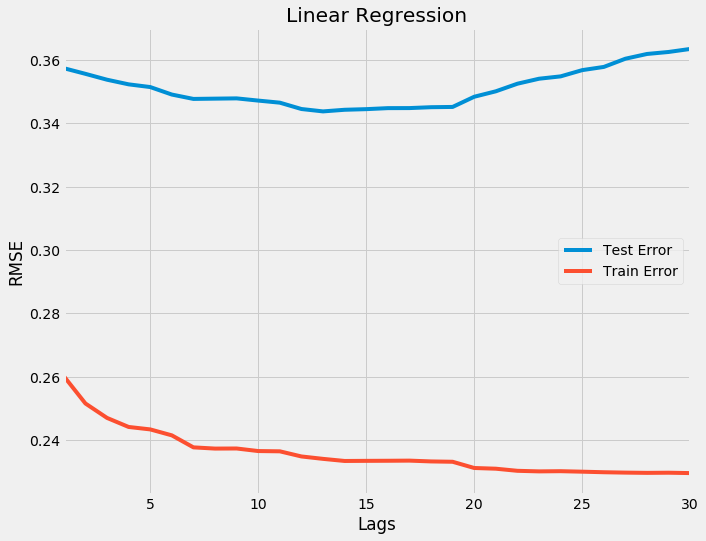

In [7]:
pd.DataFrame({'Train Error' : train_err, 'Test Error' : test_err}).set_index(np.arange(1, 31)).plot(figsize = (10, 8))
plt.xlabel('Lags')
plt.ylabel('RMSE')
plt.title('Linear Regression')
plt.show()

In [8]:
train_err = []
test_err = []
for k in range(1, 31):

    n_lag = k

    Inputs = add_lags(df, n_lag, 'Fare')

    Inputs['month'] = Inputs.index.month
    Inputs['weekday'] = Inputs.index.weekday

    Inputs['month'] = Inputs['month'].astype('category')
    Inputs['weekday'] = Inputs['weekday'].astype('category')

    train = Inputs['2013':'2016']
    test = Inputs['2017']

    target_var = ['Fare']
    #'Trip Seconds', 'Trip Miles'
    features = ['Fare_lag' + str(i) for i in range(1, n_lag+1)] + ['month', 'weekday', 'Trip Seconds', 'Trip Miles']

    # One-Hot Encoding
    X_train, y_train = pd.get_dummies(train.loc[:, features]), pd.get_dummies(train.loc[:, target_var])

    X_test, y_test = pd.get_dummies(test.loc[:, features]), pd.get_dummies(test.loc[:, target_var])

    lin_regr = LinearRegression()
    lin_regr.fit(X_train, y_train)

    init_X = X_train.iloc[-1, :n_lag].values
    init_y = y_train.values[-1]

    predicitions = []
    for i in range(len(X_test)):
        if i == 0:
            X_new = np.append(init_y, init_X)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lin_regr.predict(training)
        else:
            X_new = np.append(yhat, X_new)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lin_regr.predict(training)

        predicitions.append(yhat)

    predicitions = np.array(predicitions).ravel()
    
    training_error = sqrt(mean_squared_error(lin_regr.predict(X_train), y_train.values))
    train_err.append(training_error)

    test_error = sqrt(mean_squared_error(np.array(predicitions).flatten(), y_test.values))
    test_err.append(test_error)
    
    print('n_lag = {}'.format(k))
    print("The Train Error of Linear Regression Model is : {}".format(training_error))
    print("The Test Error of Linear Regression Model is : {}".format(test_error))
    print()

n_lag = 1
The Train Error of Linear Regression Model is : 0.23088408858145434
The Test Error of Linear Regression Model is : 0.3517445475770619

n_lag = 2
The Train Error of Linear Regression Model is : 0.22209733000814968
The Test Error of Linear Regression Model is : 0.3723383587199375

n_lag = 3
The Train Error of Linear Regression Model is : 0.21749112239066315
The Test Error of Linear Regression Model is : 0.3856201106081702

n_lag = 4
The Train Error of Linear Regression Model is : 0.21478298628132356
The Test Error of Linear Regression Model is : 0.3930091116944005

n_lag = 5
The Train Error of Linear Regression Model is : 0.21352777753904706
The Test Error of Linear Regression Model is : 0.397184231138201

n_lag = 6
The Train Error of Linear Regression Model is : 0.21116584334160737
The Test Error of Linear Regression Model is : 0.4014830579433109

n_lag = 7
The Train Error of Linear Regression Model is : 0.20821780122384143
The Test Error of Linear Regression Model is : 0.4066

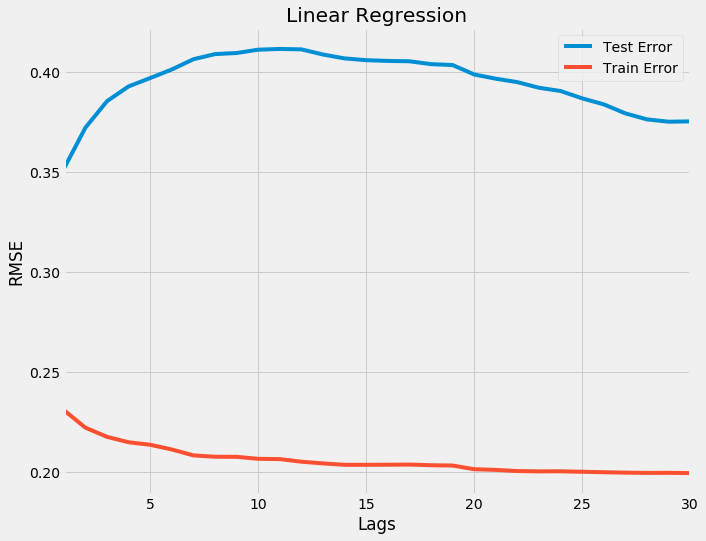

In [9]:
pd.DataFrame({'Train Error' : train_err, 'Test Error' : test_err}).set_index(np.arange(1, 31)).plot(figsize = (10, 8))
plt.xlabel('Lags')
plt.ylabel('RMSE')
plt.title('Linear Regression')
plt.show()

# Gradient Boosting Tree
- Without 'Trip Seconds' 'Trip Miles'
- With 'Trip Seconds' 'Trip Miles'

In [10]:
train_err = []
test_err = []
for k in range(1, 31):

    n_lag = k

    gbm_data = add_lags(df, n_lag, 'Fare')

    gbm_data['month'] = gbm_data.index.month
    gbm_data['weekday'] = gbm_data.index.weekday

    train = gbm_data['2013':'2016']
    test = gbm_data['2017']

    target_var = ['Fare']
    features = ['Fare_lag' + str(i) for i in range(1, n_lag+1)] + ['month', 'weekday']

    X_train, y_train = train.loc[:, features], train.loc[:, target_var]

    X_test, y_test = test.loc[:, features], test.loc[:, target_var]

    lgb_train = gbm.Dataset(X_train, y_train.values.ravel(), categorical_feature=['month', 'weekday'])

    params = {'boosting_type': 'gbdt',
              'objective': 'regression_l2',
              'metric': 'l2_root',
              'num_leaves': 5,
              'max_bin' : 50,
              'verbose': 1,
              'lambda_l1' : 0,
              'lambda_l2' : 1,
              'learning_rate' : 0.01}

    lgbm = gbm.train(params=params, 
                     train_set=lgb_train, 
                     num_boost_round=1600,
                     verbose_eval = 0)

    init_X = X_train.iloc[-1, :n_lag].values
    init_y = y_train.values[-1]

    predicitions = []
    for i in range(len(X_test)):
        if i == 0:
            X_new = np.append(init_y, init_X)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lgbm.predict(training)
        else:
            X_new = np.append(yhat, X_new)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lgbm.predict(training)

        predicitions.append(yhat)

    predicitions = np.array(predicitions).ravel()
    
    training_error = sqrt(mean_squared_error(lgbm.predict(X_train), y_train.values))
    train_err.append(training_error)

    test_error = sqrt(mean_squared_error(np.array(predicitions).flatten(), y_test.values))
    test_err.append(test_error)
    
    print('n_lag = {}'.format(k))
    print("The Train Error of LGBM is : {}".format(training_error))
    print("The Test Error of LGBM is : {}".format(test_error))
    print()

C:\Users\user\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


n_lag = 1
The Train Error of LGBM is : 0.22229111957617656
The Test Error of LGBM is : 0.42873575669305664

n_lag = 2
The Train Error of LGBM is : 0.21428305550969876
The Test Error of LGBM is : 0.39225310442768274

n_lag = 3
The Train Error of LGBM is : 0.20924409583306544
The Test Error of LGBM is : 0.3617152808900696

n_lag = 4
The Train Error of LGBM is : 0.20988941805520558
The Test Error of LGBM is : 0.36595443677631534

n_lag = 5
The Train Error of LGBM is : 0.21174656356093607
The Test Error of LGBM is : 0.389846534410289

n_lag = 6
The Train Error of LGBM is : 0.21032476950627454
The Test Error of LGBM is : 0.3716339518901147

n_lag = 7
The Train Error of LGBM is : 0.2091128885221532
The Test Error of LGBM is : 0.37806990043602523

n_lag = 8
The Train Error of LGBM is : 0.2060644669235791
The Test Error of LGBM is : 0.39340098345722607

n_lag = 9
The Train Error of LGBM is : 0.2055719536219151
The Test Error of LGBM is : 0.3790758851533652

n_lag = 10
The Train Error of LGBM i

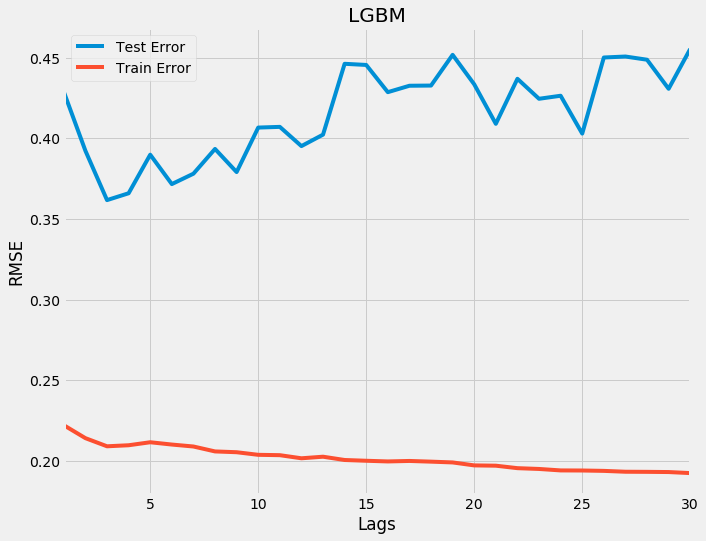

In [11]:
# Before adding Trip Seconds and Trip Miles
pd.DataFrame({'Train Error' : train_err, 'Test Error' : test_err}).set_index(np.arange(1,31)).plot(figsize = (10, 8))
plt.xlabel('Lags')
plt.ylabel('RMSE')
plt.title('LGBM')
plt.show()

In [12]:
train_err = []
test_err = []
for k in range(1, 31):

    n_lag = k

    gbm_data = add_lags(df, n_lag, 'Fare')

    gbm_data['month'] = gbm_data.index.month
    gbm_data['weekday'] = gbm_data.index.weekday

    train = gbm_data['2013':'2016']
    test = gbm_data['2017']

    target_var = ['Fare']
    features = ['Fare_lag' + str(i) for i in range(1, n_lag+1)] + ['month', 'weekday', 'Trip Seconds', 'Trip Miles']

    X_train, y_train = train.loc[:, features], train.loc[:, target_var]

    X_test, y_test = test.loc[:, features], test.loc[:, target_var]

    lgb_train = gbm.Dataset(X_train, y_train.values.ravel(), categorical_feature=['month', 'weekday'])

    params = {'boosting_type': 'gbdt',
              'objective': 'regression_l2',
              'metric': 'l2_root',
              'num_leaves': 5,
              'max_bin' : 50,
              'verbose': 1,
              'lambda_l1' : 0,
              'lambda_l2' : 1,
              'learning_rate' : 0.01}

    lgbm = gbm.train(params=params, 
                     train_set=lgb_train, 
                     num_boost_round=1600,
                     verbose_eval = 0)

    init_X = X_train.iloc[-1, :n_lag].values
    init_y = y_train.values[-1]

    predicitions = []
    for i in range(len(X_test)):
        if i == 0:
            X_new = np.append(init_y, init_X)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lgbm.predict(training)
        else:
            X_new = np.append(yhat, X_new)[:-1]
            training = np.append(X_new, X_test.iloc[i, n_lag:].values).reshape(1, -1)
            yhat = lgbm.predict(training)

        predicitions.append(yhat)

    predicitions = np.array(predicitions).ravel()
    
    training_error = sqrt(mean_squared_error(lgbm.predict(X_train), y_train.values))
    train_err.append(training_error)

    test_error = sqrt(mean_squared_error(np.array(predicitions).flatten(), y_test.values))
    test_err.append(test_error)
    
    print('n_lag = {}'.format(k))
    print("The Train Error of LGBM is : {}".format(training_error))
    print("The Test Error of LGBM is : {}".format(test_error))
    print()

C:\Users\user\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


n_lag = 1
The Train Error of LGBM is : 0.17332431228554696
The Test Error of LGBM is : 0.33510539692576086

n_lag = 2
The Train Error of LGBM is : 0.16505605359562117
The Test Error of LGBM is : 0.34395330358943355

n_lag = 3
The Train Error of LGBM is : 0.162265492237722
The Test Error of LGBM is : 0.34520155789815515

n_lag = 4
The Train Error of LGBM is : 0.1606077785471916
The Test Error of LGBM is : 0.3429576493400245

n_lag = 5
The Train Error of LGBM is : 0.1615242161232527
The Test Error of LGBM is : 0.33303115296881647

n_lag = 6
The Train Error of LGBM is : 0.16180295549443668
The Test Error of LGBM is : 0.35582117473213515

n_lag = 7
The Train Error of LGBM is : 0.15969260481254
The Test Error of LGBM is : 0.3451670251688992

n_lag = 8
The Train Error of LGBM is : 0.15571271046094906
The Test Error of LGBM is : 0.34069938221141094

n_lag = 9
The Train Error of LGBM is : 0.1563531027612501
The Test Error of LGBM is : 0.34379295818702804

n_lag = 10
The Train Error of LGBM is 

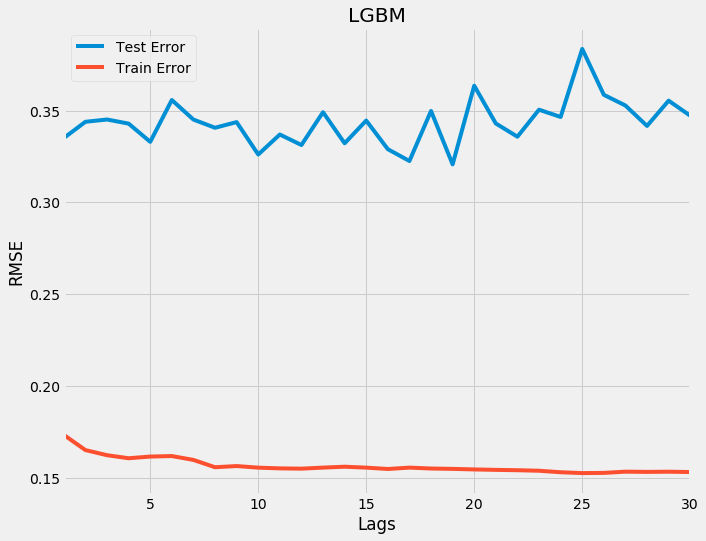

In [13]:
pd.DataFrame({'Train Error' : train_err, 'Test Error' : test_err}).set_index(np.arange(1,31)).plot(figsize = (10, 8))
plt.xlabel('Lags')
plt.ylabel('RMSE')
plt.title('LGBM')
plt.show()